<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Processamento de Linguagem Natural
## Preparação, Análise Exploratória e Representação dos Textos

**Women's E-Commerce Clothing Reviews**

Referência:
* https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

## Importação das bibliotecas

In [2]:
# Pacotes de preparação dos dados
import numpy as np
import pandas as pd
import math

# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes de manipulação de textos
import re
import string

## Importação da base de dados

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', 
                 index_col=0).sample(frac=0.1)
df

Clothing ID  Age                                           Title  \
101            863   40          Simple, stylish, lovely-runs a bit big   
6277          1110   29                                        Gorgeous   
2783           864   36                              Pretty and classic   
12366          903   47                           Super soft and pretty   
1652           835   31                                     Great shirt   
...            ...  ...                                             ...   
12867         1078   39                                             NaN   
4031           860   22  Statement sleeves leave me timeless and trendy   
5330          1011   54                           Dramatic in every way   
856            886   52                                             NaN   
14121          975   53                                             NaN   

                                             Review Text  Rating  \
101    I find that this brand can be a little bit all...       4   
6277   I absolutely love this dress. the color is bea...       5   
2783   This blouse is pretty and drapes wonderfully. ...       5   
12366  I'm happy with this sweater! a few things that...       4   
1652   This shirt is so great. it's beautiful and fun...       4   
...                                                  ...     ...   
12867                                                NaN       5   
4031   So the other review complained that there are ...       5   
5330   Love the clean lines, the texture, and the sli...       4   
856    Beautiful sweater but the material is a bit th...       4   
14121                                                NaN       4   

       Recommended IND  Positive Feedback Count   Division Name  \
101                  1                        5         General   
6277                 1                        0         General   
2783                 1                        0  General Petite   
12366                1                        4         General   
1652                 1                        1  General Petite   
...                ...                      ...             ...   
12867                1                        0  General Petite   
4031                 1                       18  General Petite   
5330                 1                        0  General Petite   
856                  1                        1  General Petite   
14121                1                        0         General   

      Department Name  Class Name  
101              Tops       Knits  
6277          Dresses     Dresses  
2783             Tops       Knits  
12366            Tops  Fine gauge  
1652             Tops     Blouses  
...               ...         ...  
12867         Dresses     Dresses  
4031             Tops       Knits  
5330          Bottoms      Skirts  
856              Tops       Knits  
14121         Jackets     Jackets  

[2349 rows x 10 columns]

## Preparação dos Dados

### Missing Values

In [4]:
df.isnull().sum()

Clothing ID                  0
Age                          0
Title                      402
Review Text                 75
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                1
Department Name              1
Class Name                   1
dtype: int64

In [10]:
df['Review Text'].isna()

101      False
6277     False
2783     False
12366    False
1652     False
         ...  
15798    False
14475    False
4031     False
5330     False
856      False
Name: Review Text, Length: 2274, dtype: bool

In [8]:
df = df.loc[~df['Review Text'].isna()] # review text tem valores nulos, o ~ inverte o resultado

In [11]:
df.isnull().sum()

Clothing ID                  0
Age                          0
Title                      327
Review Text                  0
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                1
Department Name              1
Class Name                   1
dtype: int64

### Duplicações

In [12]:
df.duplicated().sum()

0

### Tipos de Variáveis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 101 to 856
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              2274 non-null   int64 
 1   Age                      2274 non-null   int64 
 2   Title                    1947 non-null   object
 3   Review Text              2274 non-null   object
 4   Rating                   2274 non-null   int64 
 5   Recommended IND          2274 non-null   int64 
 6   Positive Feedback Count  2274 non-null   int64 
 7   Division Name            2273 non-null   object
 8   Department Name          2273 non-null   object
 9   Class Name               2273 non-null   object
dtypes: int64(5), object(5)
memory usage: 195.4+ KB


### Construção da base para NLP

In [14]:
# Pegar apenas o ID e o texto que foi escrito pelos clientes
# Seleção das variáveis para NLP
df_nlp = df[['Clothing ID','Review Text']].copy()
df_nlp.dropna(inplace=True)
df_nlp

Clothing ID                                        Review Text
101            863  I find that this brand can be a little bit all...
6277          1110  I absolutely love this dress. the color is bea...
2783           864  This blouse is pretty and drapes wonderfully. ...
12366          903  I'm happy with this sweater! a few things that...
1652           835  This shirt is so great. it's beautiful and fun...
...            ...                                                ...
15798         1092  I was really excited when i ordered this dress...
14475         1008  Have only tried on but it is a very cute skirt...
4031           860  So the other review complained that there are ...
5330          1011  Love the clean lines, the texture, and the sli...
856            886  Beautiful sweater but the material is a bit th...

[2274 rows x 2 columns]

### Preparação dos textos

* Para instalar o spacy utilize: **pip install spacy==2.3.2**
* Para instalar o modelo pré-treinado utilize: **python -m spacy download en_core_web_sm**

Os modelos disponíveis podem ser consultados na documentação da biblioteca Spacy: https://spacy.io/models

In [19]:
!pip install spacy

  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/92/fb/d1f0605e1e8627226c6c96053fe1632e9a04a3fbcd8b5d715528cb95eb97/spacy-3.7.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for spacy-legacy<3.1.0,>=3.0.11 from https://files.pythonhosted.org/packages/c3/55/12e842c70ff8828e34e543a2c7176dac4da006ca6901c9e8b43efab8bc6b/spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for spacy-loggers<2.0.0,>=1.0.0 from https://files.pythonhosted.org/packages/33/78/d1a1a026ef3af911159398c939b1509d5c36fe524c7b644f34a5146c4e16/spacy_loggers-1.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for murmurhash<1.1.0,>=0.28.0 from https://files.pythonhosted.org/packages/71/46/af01a20ec368bd9cb49a1d2df15e3eca113bbf6952cc1f2a47f1c6801a7f/murmurhash-1.0.10-cp311-cp311-win_amd64.whl.metadata
  Using cached murmurhash-1.0.10-cp311-cp311-win_amd64.whl.metadata (2.0 kB)
  Obtaining dependency information 

In [20]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 525.1 kB/s eta 0:00:25
      --------------------------------------- 0.2/12.8 MB 1.7 MB/s eta 0:00:08
      --------------------------------------- 0.3/12.8 MB 1.8 MB/s eta 0:00:08
     - -------------------------------------- 0.6/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.9 MB/s eta 0:00:05
     --- ------------------------------------ 1.3/12.8 MB 4.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.6 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB 6.0 MB/s eta 0:00:02
     ---------- ----------------------------- 3.5/12.8 MB 7.6 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 9.4 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12.8 MB 11.4 MB

In [21]:
import spacy
modelo_spacy = spacy.load('en_core_web_sm')

#### Definição das Stopwords

In [14]:
# Stopwords
modelo_spacy.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [22]:
# Exclusão de tokens na lista de stopwords
modelo_spacy.Defaults.stop_words -= {"top"}

In [ ]:
# Adição de tokens na lista de stopwords
# modelo_spacy.Defaults.stop_words |= {"token1","token2",}

In [23]:
modelo_spacy.Defaults.stop_words # top não será mais uma palavra excluída

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

#### Utilização de um Modelo Pré-Treinado

In [24]:
df_nlp.sample(5)

Clothing ID                                        Review Text
19675         1083  This dress is absolutely stunning and well mad...
22921         1020  Very high quality fabric and the fit is excell...
1652           835  This shirt is so great. it's beautiful and fun...
16663         1138  This skirt is adorable. i like it because its ...
6232           862  I really liked the fabric and look of this top...

In [27]:
# Texto de exemplo
texto = df_nlp['Review Text'][19675]
texto

'This dress is absolutely stunning and well made. it can be worn throughout the seasons. i love this designer and this dress is a masterpiece.'

In [28]:
# Aplicação do modelo Spacy
texto_spacy = modelo_spacy(texto) # gerado um objeto da classe space
texto_spacy

This dress is absolutely stunning and well made. it can be worn throughout the seasons. i love this designer and this dress is a masterpiece.

In [29]:
type(texto_spacy)

spacy.tokens.doc.Doc

In [34]:
# Análise dos tokens gerados
t = texto_spacy[2]
t

is

In [35]:
t.lemma_

'be'

In [36]:
t.text

'is'

In [37]:
t.is_stop # é stopword

True

In [38]:
t.pos_ # função da palavra na setença

'AUX'

In [43]:
# aplicaremos esta função no dataframe para facilitar a preparação
def preproc_nlp(texto, modelo_spacy=modelo_spacy):
    
    # Aplicação do modelo no texto original
    texto_spacy = list(modelo_spacy(texto))
    
    # Lista de tokens após preparação
    texto_result = list()
    
    for t in texto_spacy:
        # Remoção de pontuação
        if t.is_punct:
            continue
        # Remoção de números
        if t.is_digit:
            continue
        # Remoção de espaços extras
        if t.is_space:
            continue
        # Remoção de stopwords
        if t.is_stop:
            continue
        # Conversão para minúsculas e lematização
        texto_result.append(t.lemma_.lower())
    
    texto_result = ' '.join(texto_result)
    
    return texto_result

In [44]:
df_nlp['review_clean'] = df_nlp['Review Text'].apply(preproc_nlp)

In [45]:
df_nlp[['Review Text','review_clean']]

Review Text  \
101    I find that this brand can be a little bit all...   
6277   I absolutely love this dress. the color is bea...   
2783   This blouse is pretty and drapes wonderfully. ...   
12366  I'm happy with this sweater! a few things that...   
1652   This shirt is so great. it's beautiful and fun...   
...                                                  ...   
15798  I was really excited when i ordered this dress...   
14475  Have only tried on but it is a very cute skirt...   
4031   So the other review complained that there are ...   
5330   Love the clean lines, the texture, and the sli...   
856    Beautiful sweater but the material is a bit th...   

                                            review_clean  
101    find brand little bit place size try person bu...  
6277   absolutely love dress color beautiful saturate...  
2783   blouse pretty drape wonderfully think wide sof...  
12366  happy sweater thing help detail yoke silky tau...  
1652   shirt great beautiful functional receive count...  
...                                                  ...  
15798  excited order dress na upcoming beach vacation...  
14475  try cute skirt think comfortable wear love tex...  
4031   review complain slit sleeve blouse yes true lo...  
5330   love clean line texture slight sheen skirt run...  
856    beautiful sweater material bit thin expect han...  

[2274 rows x 2 columns]

In [46]:
linha = 0
print('Original: ', df_nlp.iloc[linha,1])
print('\n')
print('Tratado:  ', df_nlp.iloc[linha,2])

Original:  I find that this brand can be a little bit all-over-the-place with sizes. had i tried this on in person i may have bought it in a small instead of a m. despite being a bit big it still looks great and hides my flaws well. i bought a m in another shirt from them (the seamed scoop neck) and that shirt was a full 2 inches smaller in the bust than this. just something to keep in mind. still a great shirt, love the neutral color.


Tratado:   find brand little bit place size try person buy small instead m. despite bit big look great hide flaw buy m shirt seamed scoop neck shirt inch small bust mind great shirt love neutral color


## Análise Exploratória dos Textos: WordCloud

* Para instalar o wordcloud utilize: **pip install wordcloud==1.8.0**

### Analisando a base completa

In [48]:
!pip install wordcloud

In [49]:
from wordcloud import WordCloud

In [50]:
# Função para geração da WordCloud
def plot_wordcloud(wc):
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")

In [51]:
wc_texto = WordCloud(width = 1000, height = 500)\
    .generate_from_text(' '.join(df_nlp['review_clean'].to_list()))

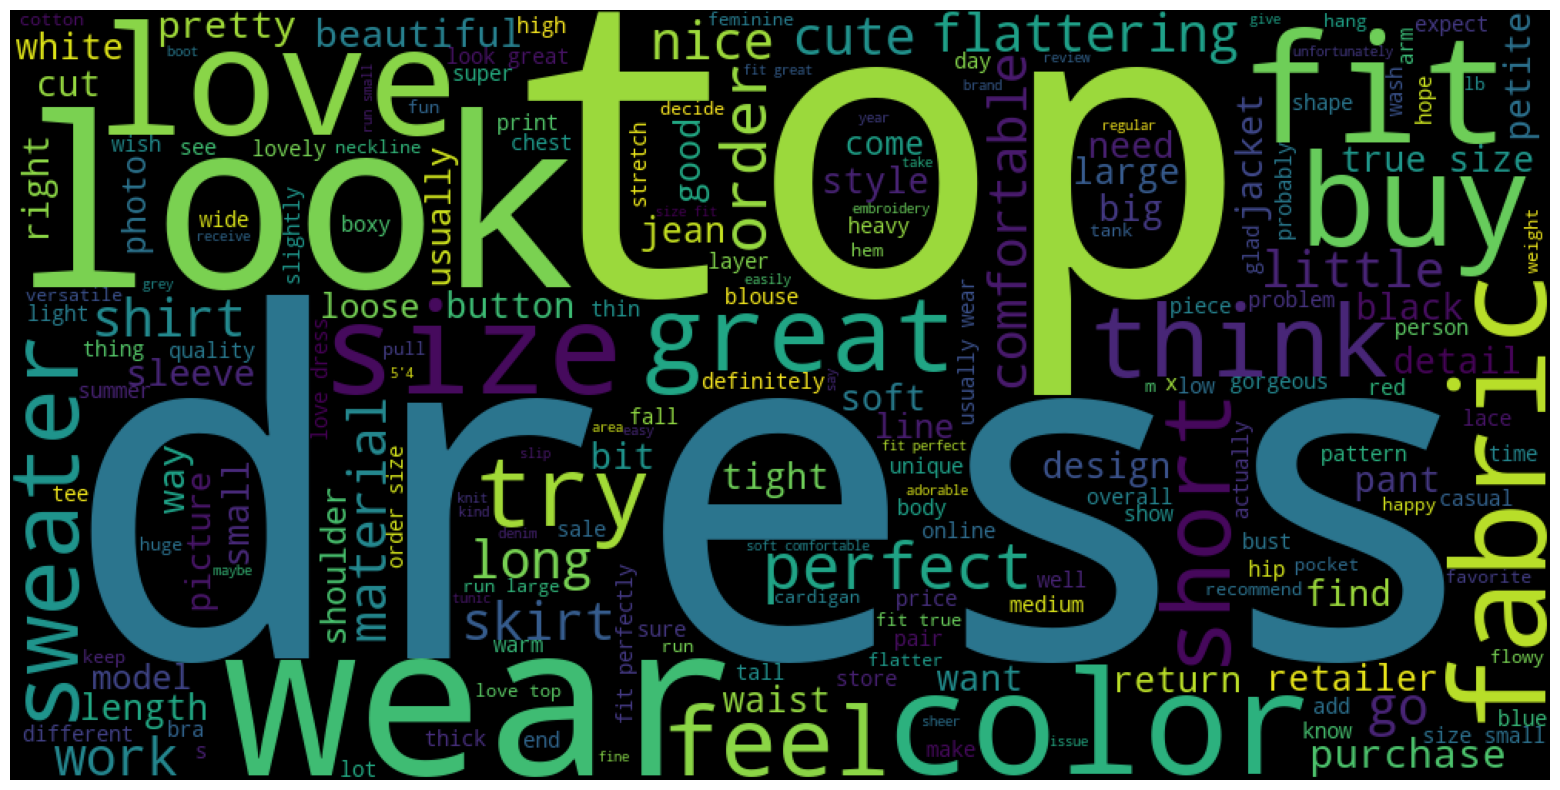

In [52]:
plot_wordcloud(wc_texto)

### Segmentando em avaliações Positivas e Negativas

In [59]:
df['avaliacao'] = np.where(df['Rating'] >= 4, 'positiva',
                           np.where(df['Rating'] <= 2,'negativa', 'neutro'))

In [60]:
import preditiva

In [61]:
preditiva.tabela_bivariada(df, 'avaliacao')

KeyError: 'avaliacao'

In [55]:
df_nlp_aval = pd.merge(left=df_nlp, right=df[['avaliacao']], 
                       how='left', left_index=True, right_index=True)

df_nlp_aval.head()

Clothing ID                                        Review Text  \
101            863  I find that this brand can be a little bit all...   
6277          1110  I absolutely love this dress. the color is bea...   
2783           864  This blouse is pretty and drapes wonderfully. ...   
12366          903  I'm happy with this sweater! a few things that...   
1652           835  This shirt is so great. it's beautiful and fun...   

                                            review_clean avaliacao  
101    find brand little bit place size try person bu...  positiva  
6277   absolutely love dress color beautiful saturate...  positiva  
2783   blouse pretty drape wonderfully think wide sof...  positiva  
12366  happy sweater thing help detail yoke silky tau...  positiva  
1652   shirt great beautiful functional receive count...  positiva

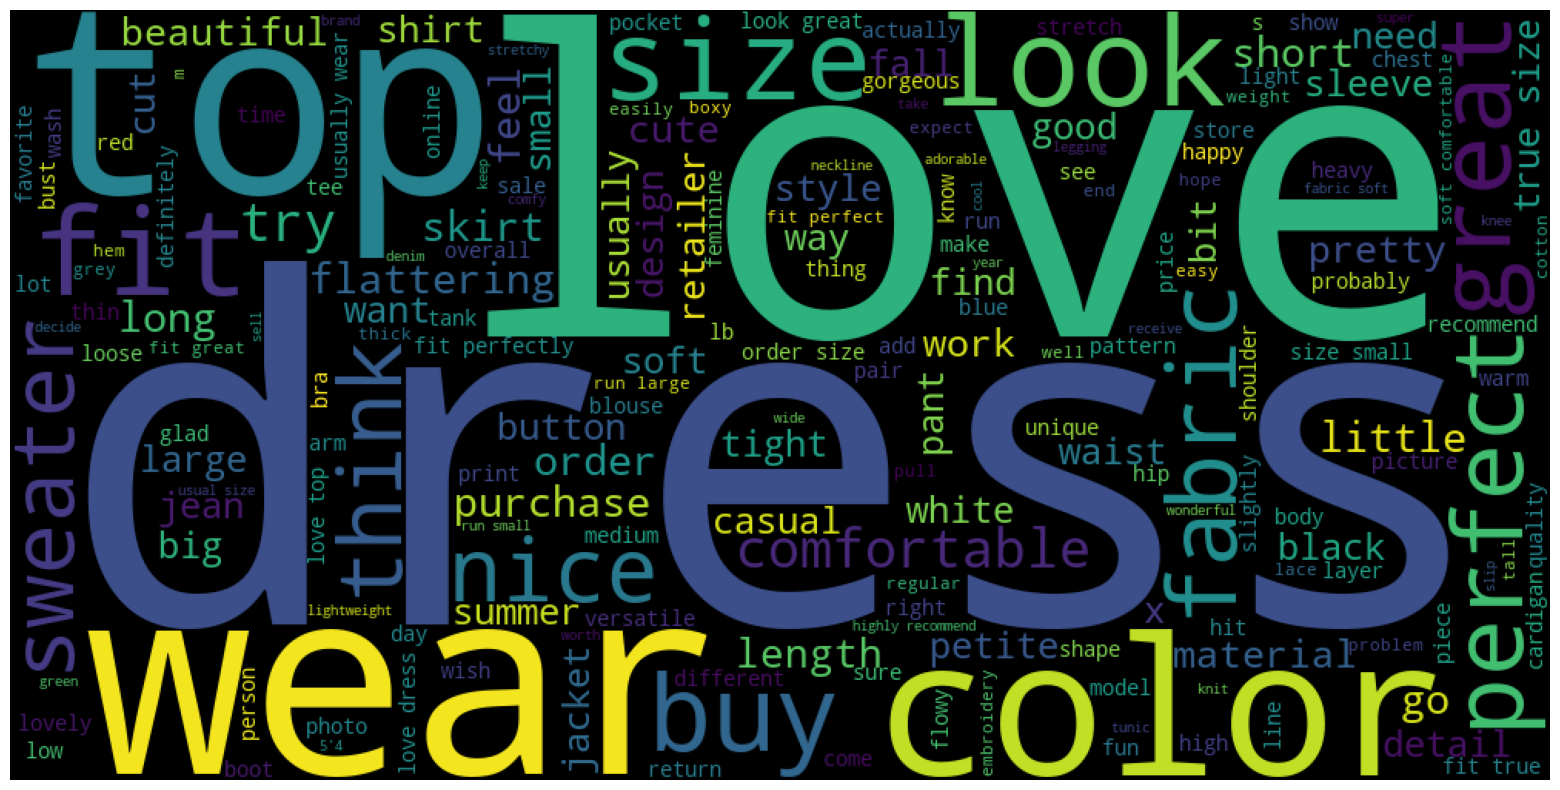

In [62]:
aval_positivas = df_nlp_aval.loc[df_nlp_aval['avaliacao']=='positiva']['review_clean'].to_list()

wc_positiva = WordCloud(width = 1000, height = 500)\
    .generate_from_text(' '.join(aval_positivas))

plot_wordcloud(wc_positiva)

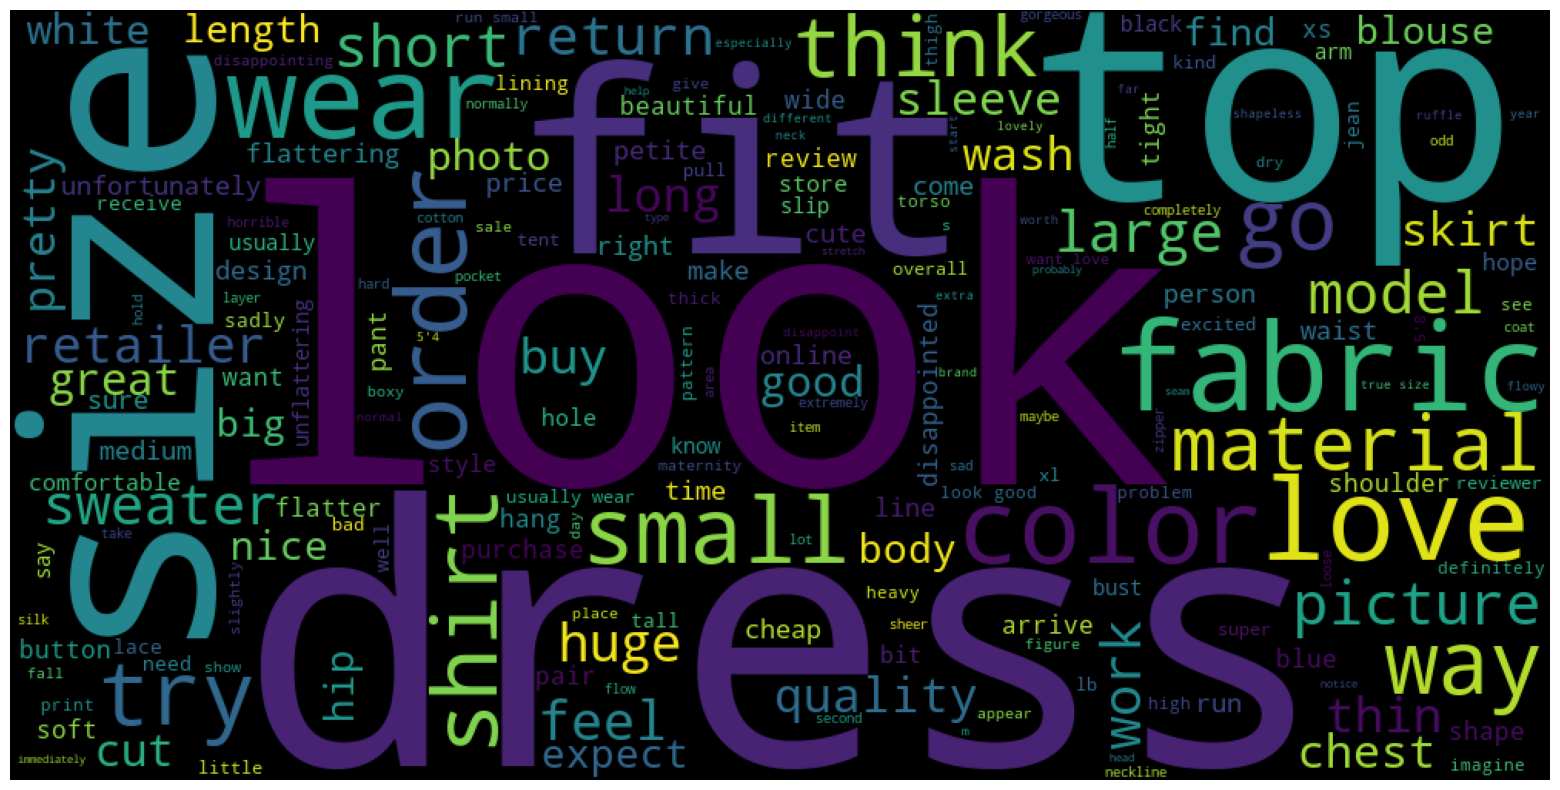

In [63]:
aval_negativas = df_nlp_aval.loc[df_nlp_aval['avaliacao']=='negativa']['review_clean'].to_list()

wc_negativa = WordCloud(width = 1000, height = 500)\
    .generate_from_text(' '.join(aval_negativas))

plot_wordcloud(wc_negativa)

## Representação de Textos

### Representação Bag of Words

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

In [79]:
# Construção da matriz Bag of Words
countvec = CountVectorizer(ngram_range=(1,2))
countvec_data = countvec.fit_transform(df_nlp_aval['review_clean'])

In [80]:
# Vocabulário criado a partir dos textos
print(countvec.vocabulary_)

{'color': 5606, 'quality': 25617, 'sweater': 32392, 'fantastic': 10736, 'reason': 25934, 'give': 13068, 'star': 30998, 'height': 14493, 'neck': 21012, 'right': 26875, 'look': 18626, 'awkward': 1747, 'high': 14652, 'leave': 17198, 'stand': 30957, 'upright': 35777, 'fold': 12364, 'wish': 37938, 'form': 12441, 'turtleneck': 35191, 'cowl': 6877, 'return': 26579, 'color quality': 5796, 'quality sweater': 25723, 'sweater fantastic': 32435, 'fantastic reason': 10748, 'reason give': 25940, 'give star': 13102, 'star height': 31003, 'height neck': 14501, 'neck right': 21057, 'right look': 26924, 'look awkward': 18637, 'awkward high': 1754, 'high leave': 14679, 'leave stand': 17214, 'stand upright': 30970, 'upright fold': 35778, 'fold wish': 12374, 'wish high': 37962, 'high form': 14671, 'form turtleneck': 12447, 'turtleneck cowl': 35194, 'cowl return': 6880, 'return sweater': 26642, 'debate': 7723, 'buy': 4253, 'glad': 13116, 'tts': 35014, '32c': 210, 'get': 12891, 'size': 29095, 'work': 38131, 

In [81]:
countvec_data

<2272x38900 sparse matrix of type '<class 'numpy.int64'>'
	with 103967 stored elements in Compressed Sparse Row format>

In [76]:
2272*38900

88380800

In [82]:
countvec_data.shape

(2272, 38900)

In [83]:
# Conversão da matriz esparsa para DataFrame
df_dtm = pd.DataFrame(countvec_data.toarray(), 
                      columns=countvec.get_feature_names())
df_dtm.index = df_nlp_aval.index
df_dtm = df_dtm.join(df_nlp_aval[['avaliacao']], how='left')
df_dtm

00p  00p 0p  00p base  00p bit  00p difference  00p order  00p xxs  0p  \
10534    0       0         0        0               0          0        0   0   
22973    0       0         0        0               0          0        0   0   
9030     0       0         0        0               0          0        0   0   
21218    0       0         0        0               0          0        0   0   
10849    0       0         0        0               0          0        0   0   
...    ...     ...       ...      ...             ...        ...      ...  ..   
19335    0       0         0        0               0          0        0   0   
11995    0       0         0        0               0          0        0   0   
2797     0       0         0        0               0          0        0   0   
17060    0       0         0        0               0          0        0   0   
9106     0       0         0        0               0          0        0   0   

       0p 00p  0p fit  ...  zipper run  zipper size  zipper sleeve  \
10534       0       0  ...           0            0              0   
22973       0       0  ...           0            0              0   
9030        0       0  ...           0            0              0   
21218       0       0  ...           0            0              0   
10849       0       0  ...           0            0              0   
...       ...     ...  ...         ...          ...            ...   
19335       0       0  ...           0            0              0   
11995       0       0  ...           0            0              0   
2797        0       0  ...           0            0              0   
17060       0       0  ...           0            0              0   
9106        0       0  ...           0            0              0   

       zipper step  zipper stick  zipper time  zipper ultimately  zoom  \
10534            0             0            0                  0     0   
22973            0             0            0                  0     0   
9030             0             0            0                  0     0   
21218            0             0            0                  0     0   
10849            0             0            0                  0     0   
...            ...           ...          ...                ...   ...   
19335            0             0            0                  0     0   
11995            0             0            0                  0     0   
2797             0             0            0                  0     0   
17060            0             0            0                  0     0   
9106             0             0            0                  0     0   

       zoom detail  avaliacao  
10534            0   negativa  
22973            0   positiva  
9030             0   negativa  
21218            0     neutro  
10849            0   positiva  
...            ...        ...  
19335            0   positiva  
11995            0   positiva  
2797             0   negativa  
17060            0   positiva  
9106             0   positiva  

[2272 rows x 38901 columns]

In [84]:
# Avaliação do número de reviews positivos e negativos para cada palavra
df_dtm_avaliacao = df_dtm.groupby('avaliacao').sum().transpose()
df_dtm_avaliacao

avaliacao          negativa  neutro  positiva
00p                       1       1         4
00p 0p                    0       0         1
00p base                  0       0         1
00p bit                   0       0         1
00p difference            0       0         1
...                     ...     ...       ...
zipper stick              0       1         2
zipper time               0       1         0
zipper ultimately         1       0         0
zoom                      0       0         1
zoom detail               0       0         1

[38900 rows x 3 columns]

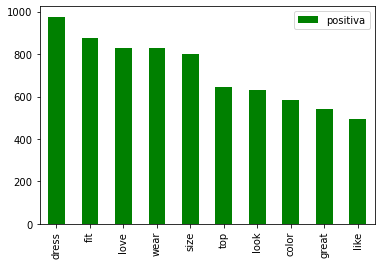

In [85]:
df_dtm_avaliacao.nlargest(10, 'positiva').plot.bar(y='positiva', color='green');

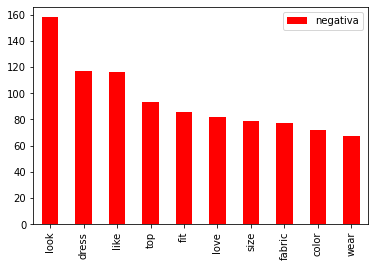

In [86]:
df_dtm_avaliacao.nlargest(10, 'negativa').plot.bar(y='negativa', color='red');

In [87]:
df_dtm_avaliacao['perc_neg'] = (df_dtm_avaliacao['negativa'] / df_dtm_avaliacao['negativa'].sum()) * 100
df_dtm_avaliacao['perc_pos'] = (df_dtm_avaliacao['positiva'] / df_dtm_avaliacao['positiva'].sum()) * 100
df_dtm_avaliacao['token'] = df_dtm_avaliacao.index.to_list()
df_dtm_avaliacao

avaliacao          negativa  neutro  positiva  perc_neg  perc_pos  \
00p                       1       1         4  0.008405   0.00472   
00p 0p                    0       0         1  0.000000   0.00118   
00p base                  0       0         1  0.000000   0.00118   
00p bit                   0       0         1  0.000000   0.00118   
00p difference            0       0         1  0.000000   0.00118   
...                     ...     ...       ...       ...       ...   
zipper stick              0       1         2  0.000000   0.00236   
zipper time               0       1         0  0.000000   0.00000   
zipper ultimately         1       0         0  0.008405   0.00000   
zoom                      0       0         1  0.000000   0.00118   
zoom detail               0       0         1  0.000000   0.00118   

avaliacao                      token  
00p                              00p  
00p 0p                        00p 0p  
00p base                    00p base  
00p bit                      00p bit  
00p difference        00p difference  
...                              ...  
zipper stick            zipper stick  
zipper time              zipper time  
zipper ultimately  zipper ultimately  
zoom                            zoom  
zoom detail              zoom detail  

[38900 rows x 6 columns]

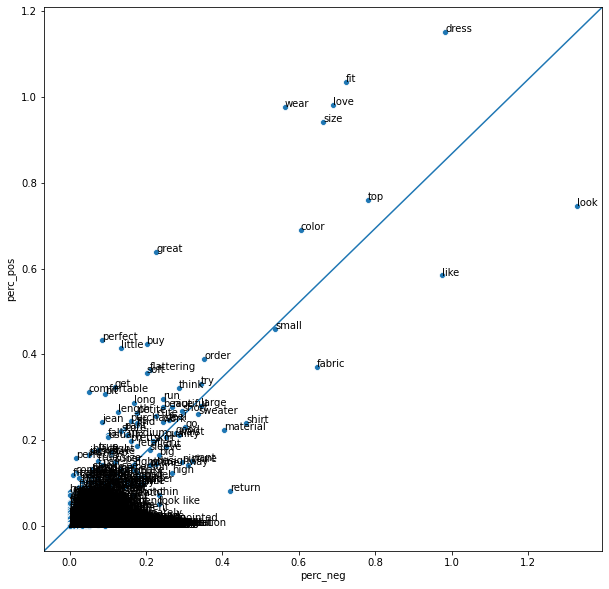

In [88]:
def plota_dispersao(df, x, y, token):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(data = df,
                         x = x, 
                         y = y)

    plt.gca()
    gca = plt.gca()
    gca.set_autoscale_on(False)
    gca.plot(gca.get_xlim(),
             gca.get_ylim())

    token = pd.concat({'x': df[x], 'y': df[y], 'token': df[token]}, axis=1)
    for i, point in token.iterrows():
        ax.text(point['x']+.00, point['y'], str(point['token']))
    
plota_dispersao(df_dtm_avaliacao, 'perc_neg', 'perc_pos', 'token');

In [89]:
# Salvamento da representação Bag of Words em arquivo
df_dtm.to_csv('df_women_bow.csv', index=True)

### Representação TF-IDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
# Construção da matriz TF-IDF
tfidfvec = TfidfVectorizer(ngram_range=(1,2))
tfidfvec_data = tfidfvec.fit_transform(df_nlp_aval['review_clean'])

In [92]:
# Vocabulário criado a partir dos textos
tfidfvec.vocabulary_

{'color': 5606,
 'quality': 25617,
 'sweater': 32392,
 'fantastic': 10736,
 'reason': 25934,
 'give': 13068,
 'star': 30998,
 'height': 14493,
 'neck': 21012,
 'right': 26875,
 'look': 18626,
 'awkward': 1747,
 'high': 14652,
 'leave': 17198,
 'stand': 30957,
 'upright': 35777,
 'fold': 12364,
 'wish': 37938,
 'form': 12441,
 'turtleneck': 35191,
 'cowl': 6877,
 'return': 26579,
 'color quality': 5796,
 'quality sweater': 25723,
 'sweater fantastic': 32435,
 'fantastic reason': 10748,
 'reason give': 25940,
 'give star': 13102,
 'star height': 31003,
 'height neck': 14501,
 'neck right': 21057,
 'right look': 26924,
 'look awkward': 18637,
 'awkward high': 1754,
 'high leave': 14679,
 'leave stand': 17214,
 'stand upright': 30970,
 'upright fold': 35778,
 'fold wish': 12374,
 'wish high': 37962,
 'high form': 14671,
 'form turtleneck': 12447,
 'turtleneck cowl': 35194,
 'cowl return': 6880,
 'return sweater': 26642,
 'debate': 7723,
 'buy': 4253,
 'glad': 13116,
 'tts': 35014,
 '32c': 

In [94]:
[df_nlp_aval.iloc[0,1]]

["The color and quality of this sweater are fantastic. the reason i only gave it two stars is that the height of the neck didn't seem right to me. it looked awkward and too high to be left standing upright, but when folded over i wished it were higher so it formed more of a turtleneck/cowl. i will be returning the sweater because of that."]

In [95]:
[df_nlp_aval.iloc[0,2]]

['color quality sweater fantastic reason give star height neck right look awkward high leave stand upright fold wish high form turtleneck cowl return sweater']

In [93]:
ex_vector = tfidfvec.transform([df_nlp_aval.iloc[0,2]])
ex_vector

<1x38900 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [96]:
ex_vector.shape

(1, 38900)

In [97]:
np.set_printoptions(threshold=38940)
ex_vector.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [98]:
np.set_printoptions(threshold=1000)

In [99]:
# Salvamento da representação TF-IDF em arquivo
df_tfidf = pd.DataFrame(data=tfidfvec_data.toarray(), 
                        index=df_nlp_aval.index,
                        columns=tfidfvec.get_feature_names())
df_tfidf

00p  00p 0p  00p base  00p bit  00p difference  00p order  00p xxs  \
10534  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
22973  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
9030   0.0     0.0       0.0      0.0             0.0        0.0      0.0   
21218  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
10849  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
...    ...     ...       ...      ...             ...        ...      ...   
19335  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
11995  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
2797   0.0     0.0       0.0      0.0             0.0        0.0      0.0   
17060  0.0     0.0       0.0      0.0             0.0        0.0      0.0   
9106   0.0     0.0       0.0      0.0             0.0        0.0      0.0   

        0p  0p 00p  0p fit  ...  zipper ribbon  zipper run  zipper size  \
10534  0.0     0.0     0.0  ...            0.0         0.0          0.0   
22973  0.0     0.0     0.0  ...            0.0         0.0          0.0   
9030   0.0     0.0     0.0  ...            0.0         0.0          0.0   
21218  0.0     0.0     0.0  ...            0.0         0.0          0.0   
10849  0.0     0.0     0.0  ...            0.0         0.0          0.0   
...    ...     ...     ...  ...            ...         ...          ...   
19335  0.0     0.0     0.0  ...            0.0         0.0          0.0   
11995  0.0     0.0     0.0  ...            0.0         0.0          0.0   
2797   0.0     0.0     0.0  ...            0.0         0.0          0.0   
17060  0.0     0.0     0.0  ...            0.0         0.0          0.0   
9106   0.0     0.0     0.0  ...            0.0         0.0          0.0   

       zipper sleeve  zipper step  zipper stick  zipper time  \
10534            0.0          0.0           0.0          0.0   
22973            0.0          0.0           0.0          0.0   
9030             0.0          0.0           0.0          0.0   
21218            0.0          0.0           0.0          0.0   
10849            0.0          0.0           0.0          0.0   
...              ...          ...           ...          ...   
19335            0.0          0.0           0.0          0.0   
11995            0.0          0.0           0.0          0.0   
2797             0.0          0.0           0.0          0.0   
17060            0.0          0.0           0.0          0.0   
9106             0.0          0.0           0.0          0.0   

       zipper ultimately  zoom  zoom detail  
10534                0.0   0.0          0.0  
22973                0.0   0.0          0.0  
9030                 0.0   0.0          0.0  
21218                0.0   0.0          0.0  
10849                0.0   0.0          0.0  
...                  ...   ...          ...  
19335                0.0   0.0          0.0  
11995                0.0   0.0          0.0  
2797                 0.0   0.0          0.0  
17060                0.0   0.0          0.0  
9106                 0.0   0.0          0.0  

[2272 rows x 38900 columns]

In [100]:
df_tfidf.to_csv('df_women_tfidf.csv')

### Word Embedding

* Para instalar o gensim utilize: **pip install gensim==3.8.3**

#### Carregar modelo pré-treinado

Faça o download do modelo pré-treinado neste link: [Modelo Mikolov](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [101]:
from gensim.models import KeyedVectors
filename = 'word_embeddings/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [102]:
# Exemplo: Rei - Homem + Mulher
result = model.most_similar(positive=['king','woman'],
                            negative=['man'], 
                            topn=1)
print(result)

[('queen', 0.7118192911148071)]


In [103]:
# Exemplo: Paris - França + Espanha
result = model.most_similar(positive=['paris', 'spain'], 
                            negative=['france'],
                            topn=1)
print(result)

[('madrid', 0.5295541286468506)]


In [104]:
# Tamanho do vocabulário
len(model.vocab)

3000000

In [105]:
model.vocab

{'</s>': <gensim.models.keyedvectors.Vocab at 0x296ac08c070>,
 'in': <gensim.models.keyedvectors.Vocab at 0x296ac08c5b0>,
 'for': <gensim.models.keyedvectors.Vocab at 0x296ac08c550>,
 'that': <gensim.models.keyedvectors.Vocab at 0x296a9d1b5b0>,
 'is': <gensim.models.keyedvectors.Vocab at 0x296a9d1bb20>,
 'on': <gensim.models.keyedvectors.Vocab at 0x296a9d1b640>,
 '##': <gensim.models.keyedvectors.Vocab at 0x296aa5f11f0>,
 'The': <gensim.models.keyedvectors.Vocab at 0x296a9f17820>,
 'with': <gensim.models.keyedvectors.Vocab at 0x296a9f17e20>,
 'said': <gensim.models.keyedvectors.Vocab at 0x296a9f172e0>,
 'was': <gensim.models.keyedvectors.Vocab at 0x296a9f17100>,
 'the': <gensim.models.keyedvectors.Vocab at 0x296a9f17310>,
 'at': <gensim.models.keyedvectors.Vocab at 0x296a9f17340>,
 'not': <gensim.models.keyedvectors.Vocab at 0x296a9d10a30>,
 'as': <gensim.models.keyedvectors.Vocab at 0x296a9d100a0>,
 'it': <gensim.models.keyedvectors.Vocab at 0x296a9d10460>,
 'be': <gensim.models.keyed

In [106]:
# Dimensão da representação vetorial
len(model['paris'])

300

In [107]:
model['paris']

array([-3.55468750e-01,  4.61425781e-02,  8.05664062e-02,  4.37500000e-01,
        1.04980469e-02,  2.18750000e-01, -1.51367188e-01, -1.09375000e-01,
       -2.28515625e-01,  5.76171875e-02, -2.24609375e-01, -2.65625000e-01,
       -3.95507812e-02, -1.37695312e-01, -8.30078125e-02,  1.52343750e-01,
        5.76171875e-02,  4.12597656e-02, -3.34472656e-02,  1.81640625e-01,
       -2.67578125e-01, -2.12890625e-01,  1.66992188e-01,  5.37109375e-02,
       -1.92382812e-01,  7.42187500e-02, -1.80664062e-01,  3.90625000e-02,
       -4.83398438e-02, -3.35937500e-01, -1.35742188e-01, -1.97265625e-01,
       -1.99218750e-01, -9.66796875e-02, -1.11328125e-01, -5.27343750e-02,
       -4.90722656e-02,  2.69531250e-01, -4.71191406e-02, -1.55273438e-01,
       -1.30859375e-01, -1.82617188e-01,  3.88671875e-01,  3.43750000e-01,
        3.47656250e-01, -1.12304688e-01,  1.42578125e-01, -6.68945312e-02,
       -1.66992188e-01,  2.14843750e-01, -2.27050781e-02,  2.96875000e-01,
        1.68945312e-01, -

#### Preparação dos textos para Word2Vec

In [108]:
df_nlp_aval

Clothing ID                                        Review Text  \
10534          929  The color and quality of this sweater are fant...   
22973         1091  I debated buying this, so glad i did. tts. i'm...   
9030           823  I thought this was adorable on the model, but ...   
21218          314  I received this top and loved the pattern. how...   
10849          437  I saw this in the store a few weeks back and d...   
...            ...                                                ...   
19335         1081  I love this dress! it's so comfortable and per...   
11995         1008  This is a very beautiful and well-made skirt. ...   
2797           997  I wish i had read the reviews prior to purchas...   
17060         1028  Good fit, quality, similar to the brand's othe...   
9106          1123  Love this so much because it's so soft, pliabl...   

                                            review_clean avaliacao  
10534  color quality sweater fantastic reason give st...  negativa  
22973  debate buy glad tts 5'5 32c get size work usua...  positiva  
9030   think adorable model actually mind try long ca...  negativa  
21218  receive top love pattern order s m bust size t...    neutro  
10849  see store week desperately want wet sale grab ...  positiva  
...                                                  ...       ...  
19335  love dress comfortable perfect summer fall tra...  positiva  
11995  beautiful skirt look little like ribbon materi...  positiva  
2797   wish read review prior purchasing skirt look a...  negativa  
17060                good fit quality similar brand jean  positiva  
9106   love soft pliable fit wonderfully fall wardrob...  positiva  

[2272 rows x 4 columns]

In [109]:
# Transformação dos textos em tokens
from gensim.utils import simple_preprocess

In [110]:
df_nlp_aval['review_clean_tokens'] = [simple_preprocess(line, deacc=False) for line in df_nlp_aval['review_clean']] 

In [111]:
df_nlp_aval

Clothing ID                                        Review Text  \
10534          929  The color and quality of this sweater are fant...   
22973         1091  I debated buying this, so glad i did. tts. i'm...   
9030           823  I thought this was adorable on the model, but ...   
21218          314  I received this top and loved the pattern. how...   
10849          437  I saw this in the store a few weeks back and d...   
...            ...                                                ...   
19335         1081  I love this dress! it's so comfortable and per...   
11995         1008  This is a very beautiful and well-made skirt. ...   
2797           997  I wish i had read the reviews prior to purchas...   
17060         1028  Good fit, quality, similar to the brand's othe...   
9106          1123  Love this so much because it's so soft, pliabl...   

                                            review_clean avaliacao  \
10534  color quality sweater fantastic reason give st...  negativa   
22973  debate buy glad tts 5'5 32c get size work usua...  positiva   
9030   think adorable model actually mind try long ca...  negativa   
21218  receive top love pattern order s m bust size t...    neutro   
10849  see store week desperately want wet sale grab ...  positiva   
...                                                  ...       ...   
19335  love dress comfortable perfect summer fall tra...  positiva   
11995  beautiful skirt look little like ribbon materi...  positiva   
2797   wish read review prior purchasing skirt look a...  negativa   
17060                good fit quality similar brand jean  positiva   
9106   love soft pliable fit wonderfully fall wardrob...  positiva   

                                     review_clean_tokens  
10534  [color, quality, sweater, fantastic, reason, g...  
22973  [debate, buy, glad, tts, get, size, work, usua...  
9030   [think, adorable, model, actually, mind, try, ...  
21218  [receive, top, love, pattern, order, bust, siz...  
10849  [see, store, week, desperately, want, wet, sal...  
...                                                  ...  
19335  [love, dress, comfortable, perfect, summer, fa...  
11995  [beautiful, skirt, look, little, like, ribbon,...  
2797   [wish, read, review, prior, purchasing, skirt,...  
17060         [good, fit, quality, similar, brand, jean]  
9106   [love, soft, pliable, fit, wonderfully, fall, ...  

[2272 rows x 5 columns]

In [112]:
# Representação vetorial da primeira frase
print(np.mean([model[token] for token in df_nlp_aval['review_clean_tokens'].values[0]], axis=0))

[ 4.38117981e-02  6.37270585e-02 -2.27228808e-03  1.06410980e-01
 -3.05455532e-02 -5.04353829e-02  1.17192589e-01 -1.48030594e-01
  1.20424904e-01  6.40818253e-02 -3.96830253e-02 -9.89990234e-02
  3.03141270e-02  3.38478088e-02 -1.27415970e-01  8.53096619e-02
  1.51201887e-02  6.37370348e-02 -2.40999851e-02 -7.55691528e-02
 -2.11639404e-02  5.13127632e-02  2.91379285e-03  4.35873680e-02
 -1.73619594e-02 -8.62731934e-02 -8.68631974e-02  8.41573104e-02
  6.86144829e-02 -5.38775139e-02 -1.76137295e-02  6.39584884e-02
  4.36655693e-02  6.17014579e-02  2.81066895e-02 -2.82815304e-02
  7.48138428e-02  2.75573730e-02 -6.34358749e-02  1.02931656e-01
  5.17985038e-02 -4.52270508e-02  8.37634429e-02 -9.67775956e-02
  2.21293774e-02 -5.03781624e-02 -5.73412590e-02 -1.91135406e-02
  1.19145714e-01  3.21063995e-02 -7.56835938e-02  1.65532436e-02
  1.45899458e-02 -4.81923437e-03  4.20112610e-02 -4.62671928e-02
 -4.37494926e-02 -3.30505371e-02 -7.51113892e-03 -4.19871025e-02
 -4.38385010e-02  9.50241

#### Transformação dos textos usando Word2Vec já treinado

In [113]:
def aplica_w2v(df, texto_tokens, modelo):
    df_nlp_w2v = pd.DataFrame()

    for index, row in df.iloc[:,:].iterrows():
        temp = pd.DataFrame()
        for token in row[texto_tokens]:
            try:
                w2v_token = modelo[token]
                temp = temp.append(pd.Series(w2v_token), ignore_index=True)
            except:
                pass
        df_nlp_w2v = df_nlp_w2v.append(temp.mean(), ignore_index=True)
        
    df_nlp_w2v.index = df.index

    return df_nlp_w2v

In [114]:
df_nlp_w2v = aplica_w2v(df_nlp_aval, 'review_clean_tokens', model)
df_nlp_w2v

0         1         2         3         4         5         6    \
10534  0.043812  0.063727 -0.002272  0.106411 -0.030546 -0.050435  0.117193   
22973  0.040678  0.030279 -0.037781  0.125207 -0.017432 -0.049331  0.125215   
9030   0.032794  0.120877 -0.030398  0.136218 -0.026514 -0.009312  0.099023   
21218  0.024464  0.059339 -0.031043  0.118214  0.018721 -0.084339  0.052358   
10849  0.027258  0.053833 -0.058205  0.087278 -0.021917 -0.013682  0.076224   
...         ...       ...       ...       ...       ...       ...       ...   
19335  0.020852  0.084577 -0.106463  0.116028 -0.058284 -0.044961  0.152693   
11995  0.013826  0.034770 -0.063559  0.083366 -0.058625 -0.021891  0.109486   
2797   0.005929  0.019362 -0.058605  0.129843 -0.021963 -0.043733  0.083452   
17060 -0.046265  0.101034 -0.032735  0.119288  0.081950  0.037994  0.112040   
9106  -0.001566  0.066946 -0.008558  0.085179 -0.011208 -0.051623  0.120323   

            7         8         9    ...       290       291       292  \
10534 -0.148031  0.120425  0.064082  ... -0.040444  0.108103 -0.085971   
22973 -0.130177 -0.016977  0.095810  ... -0.092308  0.031427 -0.057408   
9030  -0.044906  0.040895  0.075613  ... -0.102022  0.042480 -0.083354   
21218 -0.088030  0.031361  0.107144  ... -0.030796  0.066062 -0.058938   
10849 -0.098192  0.029991  0.136363  ...  0.008973  0.025071 -0.100729   
...         ...       ...       ...  ...       ...       ...       ...   
19335 -0.141765  0.040222  0.097883  ... -0.161569  0.071498 -0.138759   
11995 -0.098833  0.040357  0.090778  ... -0.050011  0.025778 -0.093870   
2797  -0.152491  0.050750  0.072295  ... -0.069135  0.047055 -0.077176   
17060 -0.079488  0.084025  0.000651  ... -0.072703  0.121989 -0.164040   
9106  -0.094292  0.008014  0.049719  ... -0.090461  0.012237 -0.048725   

            293       294       295       296       297       298       299  
10534  0.021502  0.036705 -0.053703  0.045374 -0.041807 -0.010364  0.008672  
22973 -0.027900  0.027097  0.005415  0.082912 -0.057009  0.068681 -0.017483  
9030  -0.009023 -0.089001 -0.014423  0.061467 -0.004715 -0.001182  0.009338  
21218 -0.016590  0.007625 -0.045883  0.006197 -0.041673  0.014467 -0.030833  
10849 -0.002915 -0.003282 -0.041406  0.067447 -0.079895  0.015813  0.008160  
...         ...       ...       ...       ...       ...       ...       ...  
19335 -0.121914  0.036067 -0.056449  0.059256 -0.017984 -0.000607  0.008628  
11995 -0.016342  0.014032 -0.040300  0.085748 -0.078287 -0.045535  0.044526  
2797   0.040207 -0.020793 -0.049090  0.071145 -0.084732  0.039386 -0.047223  
17060  0.038593  0.051066  0.034220  0.156148  0.000610 -0.012826  0.026367  
9106  -0.100304  0.018248 -0.048144  0.070305 -0.011378  0.045131  0.017601  

[2272 rows x 300 columns]

In [115]:
# Salvamento da representação Word2Vec Google em arquivo
df_nlp_w2v.to_csv('df_women_w2v_google.csv')

#### Treinando um modelo Word2Vec

In [116]:
from gensim.models import Word2Vec

In [117]:
my_model = Word2Vec(sentences=df_nlp_aval['review_clean_tokens'], 
                    size=100,
                    window=5,
                    min_count=1, 
                    workers=6,
                    sg=1, 
                    iter=100)

In [118]:
print(my_model)

Word2Vec(vocab=3869, size=100, alpha=0.025)


In [127]:
# Exemplo: palavra mais próxima a blusa
my_model.wv.most_similar(positive=['fantastic'], topn=3)

[('chelsea', 0.4383074641227722),
 ('drag', 0.4349448084831238),
 ('everytime', 0.43022531270980835)]

In [125]:
# Vocabulário construído
my_model.wv.vocab

{'color': <gensim.models.keyedvectors.Vocab at 0x29712834b50>,
 'quality': <gensim.models.keyedvectors.Vocab at 0x29712834be0>,
 'sweater': <gensim.models.keyedvectors.Vocab at 0x29712834c40>,
 'fantastic': <gensim.models.keyedvectors.Vocab at 0x29712834910>,
 'reason': <gensim.models.keyedvectors.Vocab at 0x29712834dc0>,
 'give': <gensim.models.keyedvectors.Vocab at 0x29712834d60>,
 'star': <gensim.models.keyedvectors.Vocab at 0x29712834eb0>,
 'height': <gensim.models.keyedvectors.Vocab at 0x29712834a90>,
 'neck': <gensim.models.keyedvectors.Vocab at 0x29712834e50>,
 'right': <gensim.models.keyedvectors.Vocab at 0x29712834fa0>,
 'look': <gensim.models.keyedvectors.Vocab at 0x29712834f40>,
 'awkward': <gensim.models.keyedvectors.Vocab at 0x29712834cd0>,
 'high': <gensim.models.keyedvectors.Vocab at 0x297128334f0>,
 'leave': <gensim.models.keyedvectors.Vocab at 0x29712833400>,
 'stand': <gensim.models.keyedvectors.Vocab at 0x297128335e0>,
 'upright': <gensim.models.keyedvectors.Vocab at

In [128]:
# Transformação dos textos usando o Word2Vec criado
df_nlp_my_w2v = aplica_w2v(df_nlp_aval, 
                           'review_clean_tokens', 
                           my_model)
df_nlp_my_w2v

<ipython-input-113-06d6ee32c253>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_token = modelo[token]


0         1         2         3         4         5         6   \
10534 -0.276926  0.004853  0.236366 -0.503003  0.323874  0.283354 -0.111078   
22973 -0.130511  0.053488  0.181874 -0.264410  0.175381  0.367443  0.031796   
9030  -0.074993 -0.006530  0.156359 -0.085853  0.168715  0.438929 -0.071933   
21218 -0.244007  0.121926  0.125164 -0.330205  0.115848  0.268198 -0.039565   
10849 -0.176660  0.065127  0.118090 -0.343145  0.066700  0.478227 -0.324060   
...         ...       ...       ...       ...       ...       ...       ...   
19335  0.017997 -0.051379  0.027889 -0.084844  0.085829  0.457506 -0.095692   
11995 -0.095473  0.040303  0.233083 -0.227259  0.191389  0.395750 -0.085874   
2797  -0.032272 -0.029496  0.214733 -0.345125  0.280088  0.357449 -0.185807   
17060  0.254912 -0.006299  0.199988 -0.301170  0.123774  0.327542 -0.296908   
9106  -0.073137 -0.070981  0.244664 -0.269657 -0.196648  0.449757 -0.027348   

             7         8         9   ...        90        91        92  \
10534  0.301404  0.104241 -0.011498  ...  0.061257  0.349526 -0.039134   
22973  0.434522  0.069983  0.331401  ...  0.058410  0.305018 -0.279663   
9030   0.290939 -0.013596  0.426117  ...  0.276369  0.171014 -0.139773   
21218  0.510206  0.060452  0.340989  ...  0.116325  0.393477 -0.163645   
10849  0.339905  0.001272  0.110146  ... -0.043228  0.267416  0.026905   
...         ...       ...       ...  ...       ...       ...       ...   
19335  0.229995 -0.145155  0.211764  ...  0.246204  0.189046  0.003922   
11995  0.226371 -0.007217  0.131752  ...  0.353250  0.225510 -0.246224   
2797   0.528679  0.033748  0.278137  ...  0.164881  0.189626 -0.248173   
17060  0.329218 -0.213395 -0.026235  ...  0.320152  0.108952 -0.172600   
9106   0.381730  0.000725  0.228877  ...  0.135886  0.259643 -0.037819   

             93        94        95        96        97        98        99  
10534 -0.018739 -0.423837 -0.273590  0.105775 -0.038622 -0.202878 -0.027837  
22973  0.011621 -0.308280 -0.123705 -0.153002  0.152523 -0.089863  0.209689  
9030   0.115294 -0.195972 -0.344380 -0.030118  0.053313 -0.066554  0.093693  
21218  0.061289 -0.409972 -0.178181 -0.168145  0.072967 -0.082673  0.022157  
10849 -0.113373 -0.257314 -0.150606 -0.403663  0.002573 -0.167198  0.049266  
...         ...       ...       ...       ...       ...       ...       ...  
19335 -0.057879 -0.228406 -0.172309 -0.076947  0.140106 -0.307111  0.074638  
11995 -0.188839 -0.411831 -0.302604 -0.267459  0.034479 -0.227573  0.097752  
2797  -0.109578 -0.500273 -0.237783 -0.082131 -0.146323  0.000093  0.182490  
17060 -0.049387 -0.182618 -0.291132 -0.430419  0.232488 -0.093170  0.099025  
9106  -0.220029 -0.302503 -0.222354 -0.269690 -0.057628 -0.185662  0.196585  

[2272 rows x 100 columns]

In [129]:
# Salvamento da representação Word2Vec prória em arquivo
df_nlp_my_w2v.to_csv('df_women_w2v_custom.csv')